In [170]:
import os
import numpy as np
import pandas as pd

import torch
from torchvision.datasets import MNIST
from captum.attr import GradientShap

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from lfxai.explanations.features import AuxiliaryFunction, attribute_auxiliary
from scipy.stats import spearmanr

from lfxai.models.images import ClassifierMnist, EncoderMnist
import copy

from matplotlib import pyplot as plt

In [14]:
# Basic setup
torch.random.manual_seed(123)
batch_size = 128
device = 'cpu'

# Model Args
image_height = 28
dim_latent = 4

In [5]:
# Data loading
data_dir = "data/mnist"
shared_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST(data_dir, train=True, download=True, transform=shared_transform
                                           )
test_dataset = MNIST(data_dir, train=False, download=True, transform=shared_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist\MNIST\raw\train-images-idx3-ubyte.gz to data/mnist\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to data/mnist\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to data/mnist\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to data/mnist\MNIST\raw



In [6]:
#### Model loading ######
# Specification
dim_latent = 4
name = "TestClassifier"
classifier_state_dict_path = os.path.join('..', 'TrainedModels', 'MNIST', 'Classifier_run0.pt') # TODO Need to loop over runs

# Load
encoder = EncoderMnist(dim_latent)

classifier = ClassifierMnist(encoder, dim_latent, name)
classifier.load_state_dict(torch.load(classifier_state_dict_path), strict=True)

encoder = copy.deepcopy(classifier.encoder) # Necessary? Should check whether the load just modifies the original

print("Classifier Loaded")

Classifier Loaded


In [7]:
# Instantiate GradShap For Encoder and Full Model
# Note this code is directly from Captum - we need to
# pass in our custom loss functions directly
gradshap_encoder = GradientShap(encoder)
gradshap_full_model = GradientShap(classifier)


In [15]:
baseline_image = torch.zeros((1, 1, 28, 28), device=device)

In [191]:
encoder_attributions = attribute_auxiliary(
                        encoder, test_loader, device, gradshap_encoder, baseline_image
                    )

# Note that this is the correct thing to do here because
pipeline_attributions = attribute_auxiliary(
    classifier, test_loader, device, gradshap_full_model, baseline_image
)



In [194]:
pd.Series(encoder_attributions.mean(axis=0).flatten()).describe()

count    784.000000
mean      -0.014048
std        1.170224
min       -5.692860
25%       -0.091688
50%        0.000000
75%        0.052898
max        6.521242
dtype: float64

In [195]:
pd.Series(pipeline_attributions.mean(axis=0).flatten()).describe()

count    784.000000
mean       0.000006
std        0.000314
min       -0.001668
25%       -0.000022
50%        0.000000
75%        0.000041
max        0.002730
dtype: float64

In [210]:
# Cast each one to absolute value, since we're not interested in the direction on the hidden space
encoder_attributions = np.abs(encoder_attributions)
pipeline_attributions = np.abs(pipeline_attributions)

# Normalise each one to have variance 1
encoder_attributions = encoder_attributions/np.std(encoder_attributions)
pipeline_attributions = pipeline_attributions/np.std(pipeline_attributions)


Text(0.5, 1.0, 'Classifier Saliency Map')

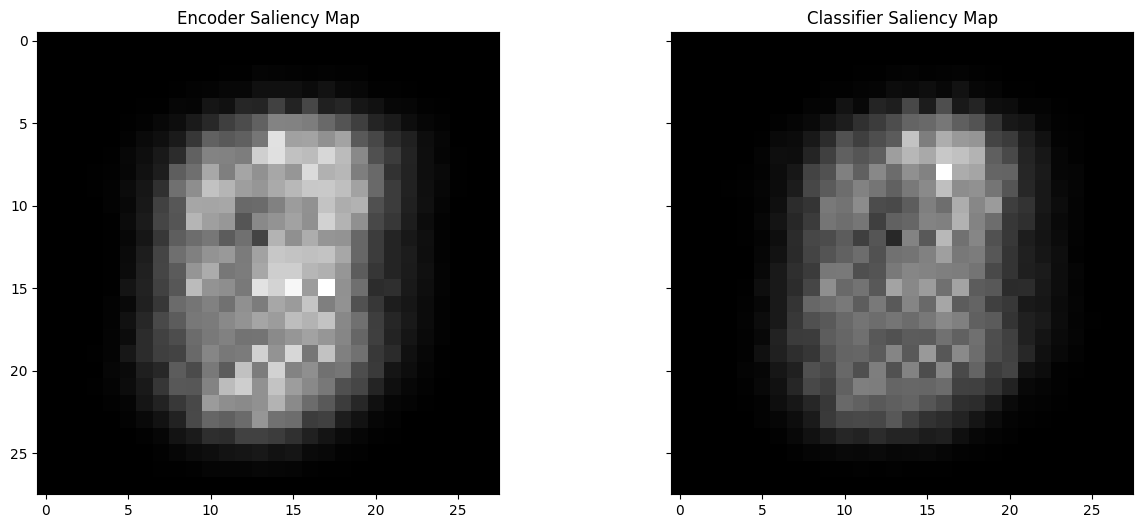

In [211]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=[15, 6])
ax[0].imshow(encoder_attributions.mean(axis=0).squeeze(), cmap='gray')
ax[0].set_title('Encoder Saliency Map')

ax[1].imshow(pipeline_attributions.mean(axis=0).squeeze(), cmap='gray')
ax[1].set_title('Classifier Saliency Map')


In [212]:
# Compute the pearson correlation between the maps
# TODO we should also exclude constant/nearly constant pixels?

# Is this correct?? Should double check.
np.corrcoef(encoder_attributions.flatten(), pipeline_attributions.flatten())

array([[1.        , 0.24141393],
       [0.24141393, 1.        ]])

(array([411.,  73.,  66.,  41.,  37.,  19.,  10.,   9.,   1.,   1.]),
 array([2.00850239e-10, 2.44970754e-01, 4.89941508e-01, 7.34912276e-01,
        9.79883015e-01, 1.22485375e+00, 1.46982455e+00, 1.71479523e+00,
        1.95976603e+00, 2.20473671e+00, 2.44970751e+00]),
 <BarContainer object of 10 artists>)

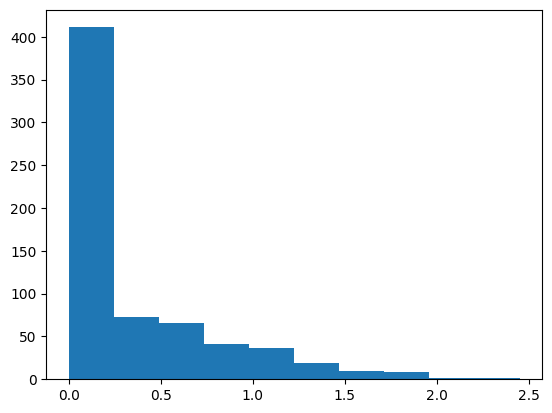

In [213]:
dots = (encoder_attributions*pipeline_attributions).mean(axis=0).squeeze()
dots = dots[dots > 0]

plt.hist(dots.flatten())

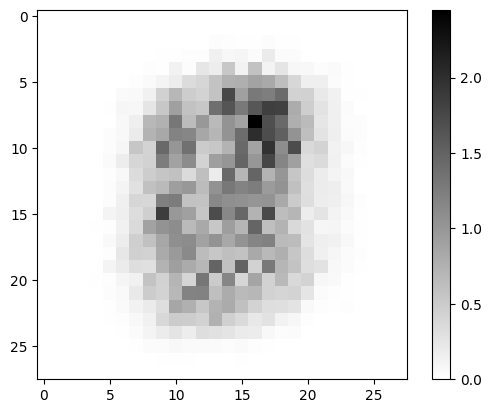

In [214]:
plt.imshow((encoder_attributions*pipeline_attributions).mean(axis=0).squeeze(), cmap='gray_r')
plt.colorbar()

#### Excluding constant pixels - NOTE probably not needed

We want to exclude pixels that are always (or almost always) black, since these will trivially be highly correlated between all methods. In the following, we mask out pixels that never have a positive feature importance value.

In [103]:
# Cod to mask out constant pixels with nan
# TODO convert this to a function

# Concatenate all the data
cats = [X for X, y in test_loader]
y = [y for X, y in test_loader]
cats = np.concatenate(cats)

mask = cats.max(axis=0) == cats.min(axis=0) # Identify all constant pixels
mask = mask[np.newaxis, ...] # Create a new axis to tile back across
mask = np.repeat(mask, cats.shape[0], axis=0) # Fill out dimensions of the new axis
cats[mask] = np.nan # Mask out constant pixels

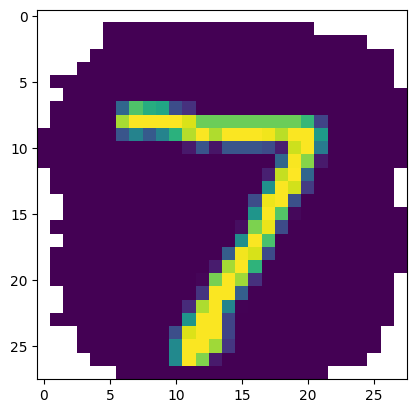

In [104]:
plt.imshow(cats[0, 0])

In [108]:
class MaskedData(Dataset):
    # TODO this feels insane - maybe someone knows an easier way
    def __init__(self, masked_data, labels, transform):
        self._data = masked_data
        self._labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        X = self._data[idx]
        X = self.transform(X)
        y = self._labels[idx]
        return X, y

In [110]:
# Now we have to load it back into a dataloader to recyle the old functions
masked_data = MaskedData(cats, y, transform=shared_transform)
masked_loader = DataLoader(masked_data, batch_size=batch_size)